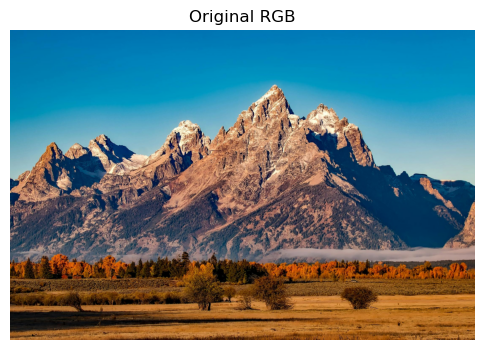

In [1]:
# %%
#  RGB <-> HSI conversion and visualization

import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Load color image (as RGB for display/math) ---
img_path = "../image2.jpg"   # <-- change to your image
bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(img_path)

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0  # [0,1]
H, W = rgb.shape[:2]

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title("Original RGB")
plt.axis("off"); plt.show()


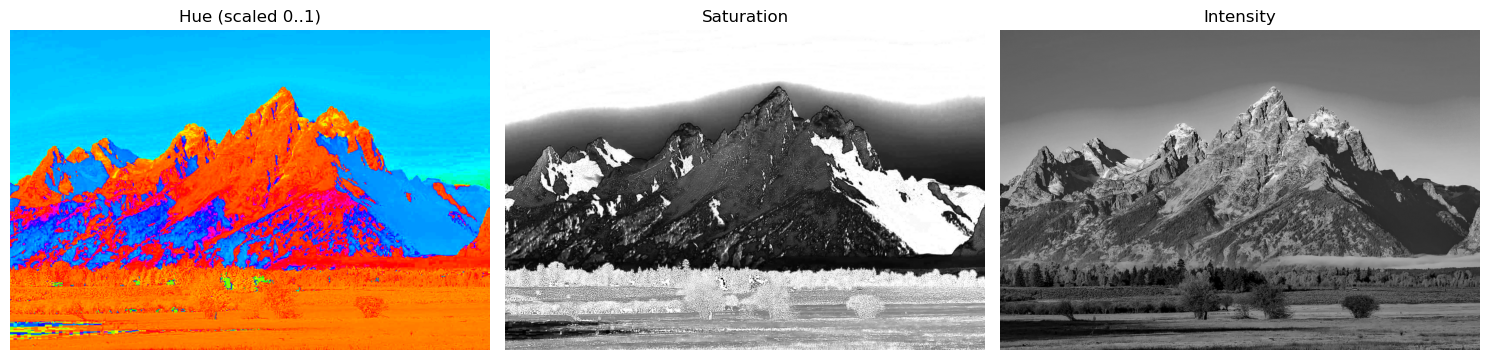

In [2]:
# %%
# RGB -> HSI (true HSI, not HSV/HSL)
# Hue in radians [0, 2π), Saturation in [0,1], Intensity in [0,1]
# Ref: Gonzalez & Woods, Digital Image Processing (HSI model)

def rgb_to_hsi(rgb01):
    R = rgb01[...,0]; G = rgb01[...,1]; B = rgb01[...,2]
    eps = 1e-8

    # Intensity
    I = (R + G + B) / 3.0

    # Saturation
    min_rgb = np.minimum(np.minimum(R, G), B)
    S = 1.0 - (3.0 * min_rgb) / (R + G + B + eps)
    S = np.clip(S, 0.0, 1.0)

    # Hue
    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G)**2 + (R - B)*(G - B)) + eps
    theta = np.arccos(np.clip(num / den, -1.0, 1.0))  # [0, π]
    H = np.where(B <= G, theta, 2*np.pi - theta)      # [0, 2π)

    return H, S, I

H, S, I = rgb_to_hsi(rgb)

# Display H, S, I
# For visualization: map H from [0,2π) to [0,1]
H_vis = (H / (2*np.pi)).astype(np.float32)
S_vis = S.astype(np.float32)
I_vis = I.astype(np.float32)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(H_vis, cmap="hsv"); ax[0].set_title("Hue (scaled 0..1)"); ax[0].axis("off")
ax[1].imshow(S_vis, cmap="gray"); ax[1].set_title("Saturation"); ax[1].axis("off")
ax[2].imshow(I_vis, cmap="gray"); ax[2].set_title("Intensity"); ax[2].axis("off")
plt.tight_layout(); plt.show()


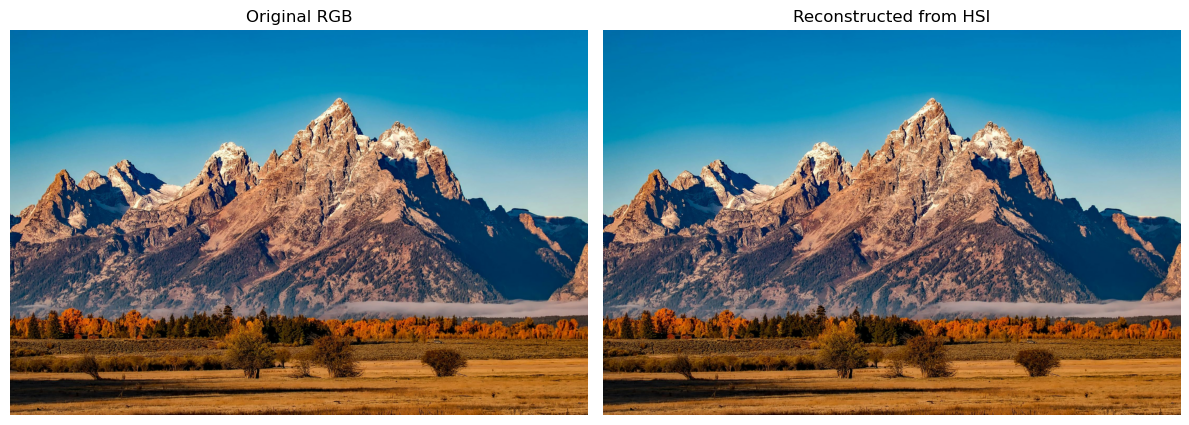

In [3]:
# %%
# HSI -> RGB (inverse)
# Using piecewise equations:
#   For 0 ≤ H < 2π/3 (RG sector), 2π/3 ≤ H < 4π/3 (GB), 4π/3 ≤ H < 2π (BR)
# See Gonzalez & Woods.

def hsi_to_rgb(H, S, I):
    H = H % (2*np.pi)
    S = np.clip(S, 0.0, 1.0)
    I = np.clip(I, 0.0, 1.0)

    R = np.zeros_like(I)
    G = np.zeros_like(I)
    B = np.zeros_like(I)

    # sector 1: 0..2π/3  (RG)
    idx = (H >= 0) & (H < 2*np.pi/3)
    h = H[idx]
    cos_h   = np.cos(h)
    cos_60h = np.cos(np.pi/3 - h) + 1e-8
    B[idx] = I[idx] * (1 - S[idx])
    R[idx] = I[idx] * (1 + (S[idx] * cos_h / cos_60h))
    G[idx] = 3*I[idx] - (R[idx] + B[idx])

    # sector 2: 2π/3..4π/3 (GB)
    idx = (H >= 2*np.pi/3) & (H < 4*np.pi/3)
    h = H[idx] - 2*np.pi/3
    cos_h   = np.cos(h)
    cos_60h = np.cos(np.pi/3 - h) + 1e-8
    R[idx] = I[idx] * (1 - S[idx])
    G[idx] = I[idx] * (1 + (S[idx] * cos_h / cos_60h))
    B[idx] = 3*I[idx] - (R[idx] + G[idx])

    # sector 3: 4π/3..2π (BR)
    idx = (H >= 4*np.pi/3) & (H < 2*np.pi)
    h = H[idx] - 4*np.pi/3
    cos_h   = np.cos(h)
    cos_60h = np.cos(np.pi/3 - h) + 1e-8
    G[idx] = I[idx] * (1 - S[idx])
    B[idx] = I[idx] * (1 + (S[idx] * cos_h / cos_60h))
    R[idx] = 3*I[idx] - (G[idx] + B[idx])

    rgb = np.stack([R, G, B], axis=-1)
    rgb = np.clip(rgb, 0.0, 1.0)
    return rgb

rgb_recon = hsi_to_rgb(H, S, I)
rgb_recon_u8 = (rgb_recon * 255 + 0.5).astype(np.uint8)

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow((rgb*255+0.5).astype(np.uint8))
ax[0].set_title("Original RGB"); ax[0].axis("off")
ax[1].imshow(rgb_recon_u8)
ax[1].set_title("Reconstructed from HSI"); ax[1].axis("off")
plt.tight_layout(); plt.show()


In [4]:
# %%
# Sanity check: reconstruction error

err = np.mean(np.abs(rgb - rgb_recon))
print(f"Mean absolute reconstruction error (RGB in [0,1]): {err:.6f}")


Mean absolute reconstruction error (RGB in [0,1]): 0.000000


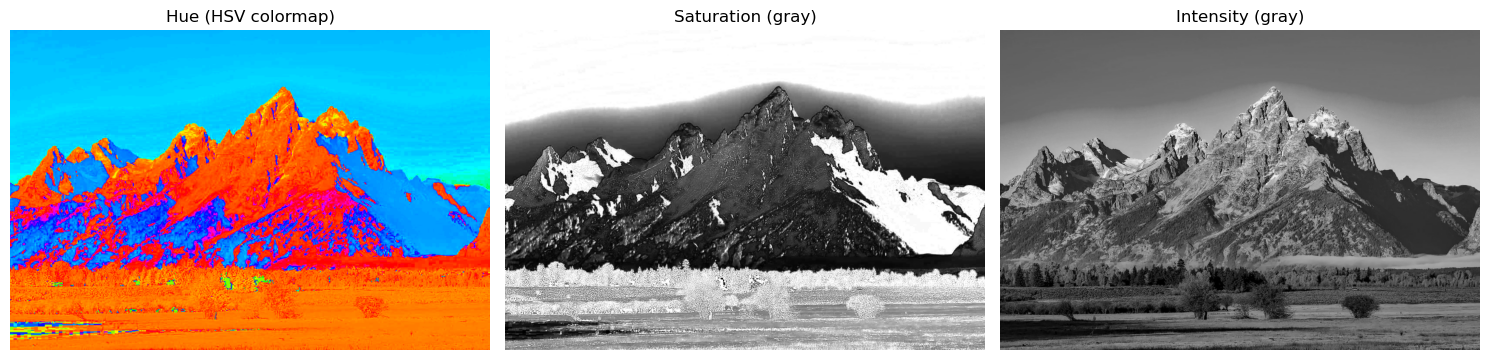

In [5]:

H_rgb = plt.cm.hsv(H_vis)[..., :3]                     # HSV colormap for hue
S_rgb = np.stack([S_vis]*3, axis=-1)                   # gray triplet
I_rgb = np.stack([I_vis]*3, axis=-1)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow((H_rgb*255).astype(np.uint8)); ax[0].set_title("Hue (HSV colormap)"); ax[0].axis("off")
ax[1].imshow((S_rgb*255).astype(np.uint8)); ax[1].set_title("Saturation (gray)"); ax[1].axis("off")
ax[2].imshow((I_rgb*255).astype(np.uint8)); ax[2].set_title("Intensity (gray)"); ax[2].axis("off")
plt.tight_layout(); plt.show()
